In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.optimize import curve_fit

In [2]:
a, a_err = 3.1304347826086867e-06, 3.1304347826086867e-06
resolution, resolution_err = 0.018835915624440338, 0.00012187430782578249
c = 360/25600

In [3]:
def gaussian2d(xdata, A, mu_x, mu_y, sigma, C):
    return A * np.exp(-((xdata[0] - mu_x) ** 2 + (xdata[1] - mu_y) ** 2) / (2 * sigma ** 2)) + C

## Data

In [4]:
data = pd.read_csv(
    './data/unknown_raw.csv', 
    comment='#',
    skip_blank_lines=True,
    skipinitialspace=True,
    header=None,
    names=['x', 'theta', 'time', 'ch1', 'ch2', 'coincidences']
)

data['x'] *= a
data['theta'] *= c
data = data[data['theta'] != 171]

x = np.sort(data['x'].unique())
theta = np.sort(data['theta'].unique())  # in degrees

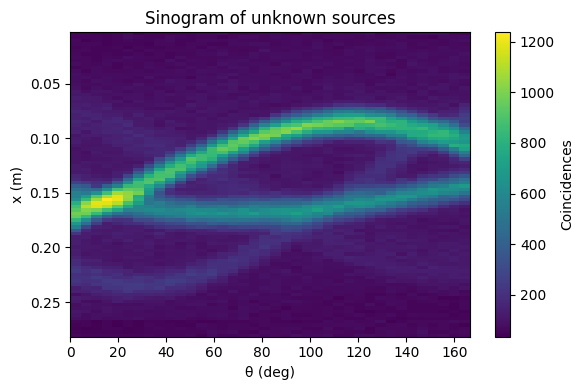

In [5]:
# 2. Pivot into sinogram array
sinogram_df = data.pivot(
    index='x',
    columns='theta',
    values='coincidences'
)
sinogram = sinogram_df.loc[x, theta].values
sinogram = np.roll(sinogram, -5, axis=0)

# 3. Display the sinogram
fig, ax = plt.subplots(figsize=(6, 4))
img = ax.imshow(
    sinogram,
    aspect='auto',
    extent=[
        theta.min(), theta.max(),
        x.max(), x.min()
    ]
)
ax.set_xlabel("θ (deg)")
ax.set_ylabel("x (m)")
ax.set_title("Sinogram of unknown sources")

fig.colorbar(img, ax=ax, label='Coincidences')
plt.tight_layout()

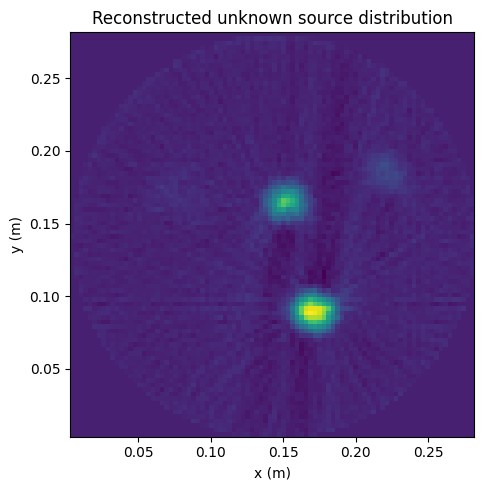

In [6]:
# 4. Perform filtered back‐projection (inverse Radon transform)
reconstruction = iradon(sinogram, theta=theta)

# 5. Display the reconstruction

fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)

ax.set_title('Reconstructed unknown source distribution')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

plt.tight_layout()

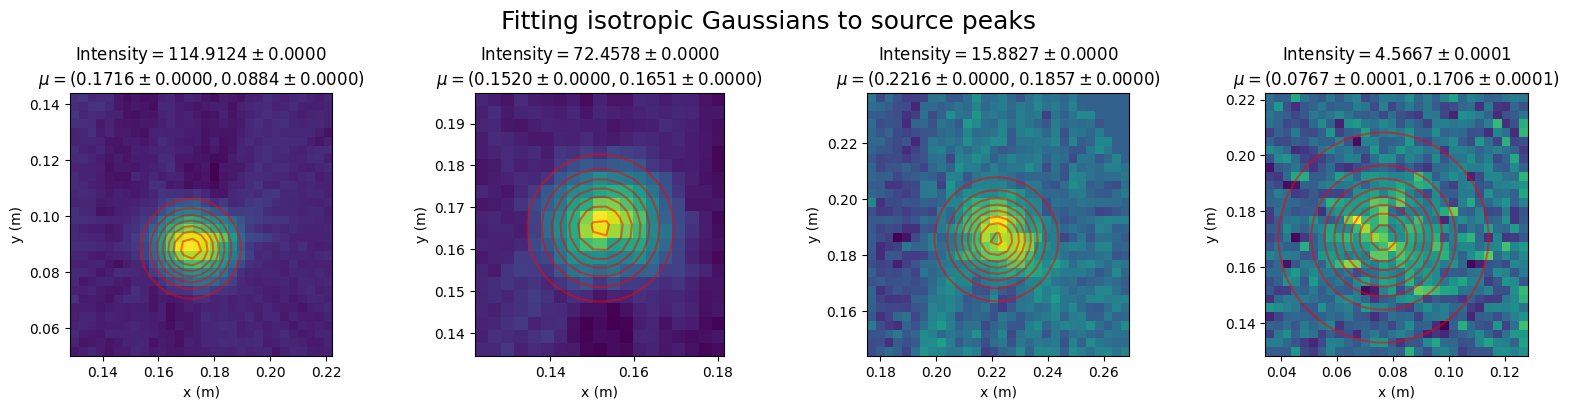

In [7]:
sources = [(40, 70, 45, 75), (38, 57, 28, 48), (55, 85, 15, 45), (10, 40, 20, 50)]
fig, axs = plt.subplots(1, len(sources), figsize=(4 * len(sources), 4))

positions = []
position_errs = []
intensities, intensity_errs = [], []
for (x0, x1, y0, y1), ax in zip(sources, axs):

    # Plot reconstruction

    peak = reconstruction[y0:y1, x0:x1]

    ax.imshow(
        peak,
        extent=[x[x0], x[x1], x[90 - y1], x[90 - y0]]
    )
    ax.set_title('Source')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')

    # Fit gaussian
    
    coord_x, coord_y = np.meshgrid(x[x0 : x1], x[90 - y0 - 1: 90 - y1 - 1: -1])
    coord_z = peak
    
    peak_max = np.unravel_index(coord_z.argmax(), coord_z.shape)
    params_0 = [coord_z.max() - coord_z.min(), coord_x[peak_max], coord_y[peak_max], 0.01, coord_z.min()]
    params, params_cov = curve_fit(
        gaussian2d,
        (coord_x.ravel(), coord_y.ravel()),
        coord_z.ravel(),
        p0=params_0, 
        sigma = 0.1 * np.ones_like(coord_z).ravel(), 
        absolute_sigma=True
    )
    params_err = np.sqrt(np.diag(params_cov))
    
    positions.append((params[1], params[2]))
    position_errs.append((params_err[1], params_err[2]))
    intensities.append(params[0])
    intensity_errs.append(params_err[0])

    # Plot contour
    ax.contour(
        coord_x, coord_y, 
        gaussian2d((coord_x, coord_y), *params), 
        colors='r', 
        alpha=0.5
    )
    
    ax.set_title( 
        f'Intensity$ = {params[0]:.4f} \pm {params_err[1]:.4f}$\n' + 
        f'$\mu=({params[1]:.4f}\pm{params_err[1]:.4f}, {params[2]:.4f}\pm{params_err[1]:.4f})$'
    )
    ax.set_aspect('equal')
    
fig.suptitle('Fitting isotropic Gaussians to source peaks', fontsize=18)
plt.tight_layout()
fig.savefig('./figures/unknown_fitting.pdf')

In [17]:
x[0] ** 2

9.799621928166296e-06

In [11]:
positions = np.array(positions)
position_errs = np.array(position_errs)

pd.DataFrame(dict(
    x=positions[:, 0], x_err=position_errs[:, 0], 
    y=positions[:, 1], y_err=position_errs[:, 1], 
    intensity=intensities, intensity_err=intensity_errs
)).style.to_latex()

'\\begin{tabular}{lrrrrrr}\n & x & x_err & y & y_err & intensity & intensity_err \\\\\n0 & 0.171570 & 0.000002 & 0.088443 & 0.000002 & 114.912353 & 0.028583 \\\\\n1 & 0.152015 & 0.000003 & 0.165061 & 0.000003 & 72.457780 & 0.028878 \\\\\n2 & 0.221620 & 0.000016 & 0.185696 & 0.000016 & 15.882722 & 0.025075 \\\\\n3 & 0.076663 & 0.000055 & 0.170644 & 0.000055 & 4.566706 & 0.018906 \\\\\n\\end{tabular}\n'

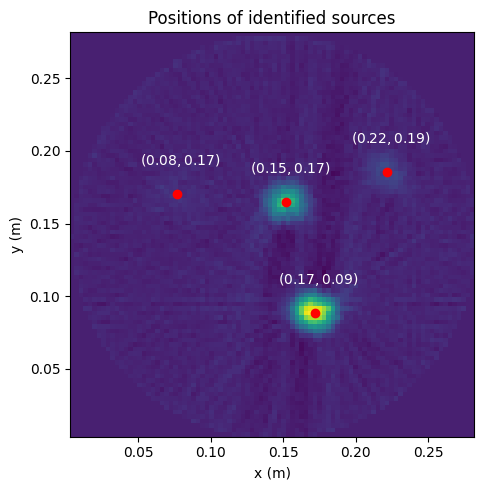

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.imshow(
    reconstruction,
    extent=[x.min(), x.max(), x.min(), x.max()]
)

ax.scatter(positions[:, 0], positions[:, 1], color='r')
for (pos_x, pos_y), (pos_x_err, pos_y_err) in zip(positions, position_errs):
    ax.annotate(
        f'$({pos_x:.2f}, {pos_y:.2f})$', 
        xy=(pos_x, pos_y), xytext=(pos_x - 0.025, pos_y + 0.02), 
        color='w'
    )

ax.set_title('Positions of identified sources')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

plt.tight_layout()

fig.savefig('./figures/unknown_positions.pdf')